<h2> Ember Data Preprocessing To get the Features </h2>

In [1]:
import os
import re
import json
import lief
import hashlib
import tqdm
import numpy as np
import pandas as pd
import multiprocessing
from sklearn.feature_extraction import FeatureHasher
import seaborn as sns

<h4> Make sure these file are present in the same directory </h4>
<h5>extract_binary_features.py is a customized script to extract features given a executables directory </h5>
<h5>ember_dataset.py is a customized script to extract ember  features from ember dataset. </h5>
<h5> i have tweaked the original ember codes sligtly to get these scripts as per my requirement </h5>

In [2]:
!ls *.py

ember_dataset.py  extract_binary_features.py


In [13]:
from extract_binary_features import extract_features
from ember_dataset import create_data,read_metadata,read_vectorized_features


<h4> Made a custom script to generate features given a directory of PE files </h4>
<h5> The executables Dir contains 24 PE files </h5>

In [14]:
executables_dir ="../executables"
!ls ../executables

CheckNetIsolation.exe  cipher.exe    icacls.exe
chglogon.exe	       find.exe      IcsEntitlementHost.exe
chgport.exe	       findstr.exe   icsunattend.exe
chgusr.exe	       finger.exe    InfDefaultInstall.exe
chkdsk.exe	       fixmapi.exe   iscsicpl.exe
chkntfs.exe	       fltMC.exe     ktmutil.exe
choice.exe	       help.exe      label.exe
CIDiag.exe	       HOSTNAME.EXE  Locator.exe


<h4> Ember feature_version=1 gives 2351 features per PE file  </h4>

In [5]:
features =extract_features(executables_dir,feature_version=1)
features.shape

(24, 2351)

<h4> Ember feature_version=2 gives 2381 features per PE file  </h4>

In [6]:
features =extract_features(executables_dir,feature_version=2)
features.shape

(24, 2381)

In [7]:
features

array([[0.46194774, 0.00855334, 0.00404095, ..., 0.        , 0.        ,
        0.        ],
       [0.39925656, 0.0108997 , 0.00321321, ..., 0.        , 0.        ,
        0.        ],
       [0.35704628, 0.00661058, 0.00424429, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.39425224, 0.01004464, 0.00507812, ..., 0.        , 0.        ,
        0.        ],
       [0.39185473, 0.01005498, 0.00426794, ..., 0.        , 0.        ,
        0.        ],
       [0.31587839, 0.01332876, 0.004091  , ..., 0.        , 0.        ,
        0.        ]])

<h3> Ember provides 3 datasets I have used ember2018 Dataet </h3>

In [8]:
ember2018 = '../Dataset/ember_zip/ember2018'

<h5> Which initially contains *.jsonl files and a pretrained lightgbm trained model file ember_model_2018.txt
The dataset size is almost 10GB </h5> 

In [9]:
!ls '../Dataset/ember_zip/ember2018'

ember2018_test_data.npz   test_metadata.csv	  train_features_5.jsonl
ember2018_train_data.npz  train_features_0.jsonl  train_metadata.csv
ember_model_2018.txt	  train_features_1.jsonl  X_test.dat
metadata.csv		  train_features_2.jsonl  X_train.dat
model2018.txt		  train_features_3.jsonl  y_test.dat
test_features.jsonl	  train_features_4.jsonl  y_train.dat


<h5> If the .dat files are not present execute below command, which creates numpy dat files which can be used for training" </h5> 

In [10]:
create_data(ember2018,feature_version=2)

In [11]:
!ls '../Dataset/ember_zip/ember2018'

ember2018_test_data.npz   test_metadata.csv	  train_features_5.jsonl
ember2018_train_data.npz  train_features_0.jsonl  train_metadata.csv
ember_model_2018.txt	  train_features_1.jsonl  X_test.dat
metadata.csv		  train_features_2.jsonl  X_train.dat
model2018.txt		  train_features_3.jsonl  y_test.dat
test_features.jsonl	  train_features_4.jsonl  y_train.dat


<h4>metadata.csv file contains info about the pefiles which can be seen as below</h4>
<h5> label =0 represents benign, label=1 reprsents malware</h5>

In [12]:
meta_data = read_metadata(ember2018)
meta_data


,sha256,appeared,label,avclass,subset
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,2006-12,0,NaN,train
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,2007-01,0,NaN,train
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,2007-02,0,NaN,train
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,2007-02,0,NaN,train
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,2007-02,0,NaN,train
...,...,...,...,...,...
999995,e033bc4967ce64bbb5cafdb234372099395185a6e0280c...,2018-12,1,zbot,test
999996,c7d16736fd905f5fbe4530670b1fe787eb12ee86536380...,2018-12,1,flystudio,test
999997,0020077cb673729209d88b603bddf56b925b18e682892a...,2018-12,0,NaN,test
999998,1b7e7c8febabf70d1c17fe3c7abf80f33003581c380f28...,2018-12,0,NaN,test


<h4> More frequent malware classes in the Dataset </h4>

In [13]:
A = meta_data['avclass'].value_counts()
A[A>11000]

xtrat             41564
zbot              27656
ramnit            23999
installmonster    22199
sality            21750
zusy              18766
vtflooder         16164
emotet            15624
fareit            14382
adposhel          11756
Name: avclass, dtype: int64

<h4> Loading the  Dataset </h4>

In [14]:
( X_train, y_train, X_test, y_test) = read_vectorized_features(ember2018, subset=None, feature_version=2)

<h4> Train Dataset Contains 300000 benign,300000 Malware samples and 200000 unlabeled samples  </h4>

[-1.  0.  1.] [200000 300000 300000]


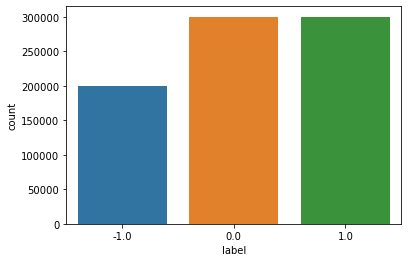

In [15]:
values, counts = np.unique(y_train, return_counts=True)
print (values,counts)
df = pd.DataFrame(data=y_train, columns=["label"])
sns.countplot(x = 'label', data=df);

<h4> Test Dataset Contains 100000 benign and  100000 Malware samples  </h4>

[0. 1.] [100000 100000]


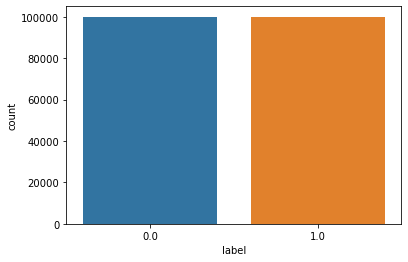

In [16]:
values, counts = np.unique(y_test, return_counts=True)
print (values,counts)
df = pd.DataFrame(data=y_test, columns=["label"])
sns.countplot(x = 'label', data=df);

<h4> Removed unlabel samples and saved the train and test datset in the files ember2018_train_data.npz,ember2018_test_data.npz
 for future use</h4>

In [17]:
train = np.column_stack((X_train,y_train))
test = np.column_stack((X_test,y_test))

In [18]:
rows = np.where(train[:,-1]!=-1)
train[rows].shape

(600000, 2382)

In [19]:
np.savez(os.path.join(ember2018,'ember2018_train_data.npz'),train[rows][:,:2381],train[rows][:,2381])

In [20]:
np.savez(os.path.join(ember2018,'ember2018_test_data.npz'),test[:,:2381],test[:,2381])

In [21]:
npzfile = np.load(os.path.join(ember2018,'ember2018_train_data.npz'),allow_pickle=True)

In [22]:
npzfile['arr_0'].shape

(600000, 2381)

In [23]:
npzfile['arr_1'].shape

(600000,)

In [24]:
npzfile = np.load(os.path.join(ember2018,'ember2018_test_data.npz'),allow_pickle=True)

In [25]:
npzfile['arr_0'].shape,npzfile['arr_1'].shape

((200000, 2381), (200000,))

In [26]:
!ls -l ../Dataset/ember_zip/ember2018/*.npz

-rw-r--r-- 1 mcs192792 mcs19 1905600486 May 14 23:28 ../Dataset/ember_zip/ember2018/ember2018_test_data.npz
-rw-r--r-- 1 mcs192792 mcs19 5716800594 May 14 23:28 ../Dataset/ember_zip/ember2018/ember2018_train_data.npz
